# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

## import

In [86]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F

import copy

## Configuration and Setup

In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 2022
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Read train and test data to dataframe to prepare the data

In [5]:
df = pd.read_csv('../../data/tempseries_labeled.zip')

In [7]:
df

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,...,otemp10,otemp11,otemp12,otemp13,otemp14,otemp15,loc,start,end,ab_label
0,71.3,73.5,73.8,70.6,72.2,74.6,72.0,70.7,73.3,73.4,...,68.00,68.0,68.0,75.9,69.1,69.1,S12,2022-07-29 10:45:00-07:00,2022-07-29 14:45:00-07:00,0
1,76.3,77.8,77.4,76.5,76.6,77.6,77.1,76.2,73.5,74.9,...,66.45,66.0,66.0,64.0,64.0,64.0,W40,2022-06-08 14:45:00-07:00,2022-06-08 18:45:00-07:00,0
2,73.4,73.7,73.6,73.5,73.4,73.5,73.7,73.8,73.7,73.5,...,55.40,56.3,57.2,55.4,55.4,55.4,M80,2022-06-30 15:30:00-07:00,2022-06-30 19:30:00-07:00,0
3,77.9,78.0,78.2,78.1,78.0,77.9,78.1,78.2,78.1,78.2,...,75.90,75.9,75.9,77.0,73.9,73.9,C30,2022-06-05 13:30:00-07:00,2022-06-05 17:30:00-07:00,0
4,72.4,73.0,73.2,73.0,72.1,71.8,72.2,71.8,72.3,72.5,...,84.00,84.0,82.9,82.9,82.9,82.0,L30,2022-08-12 12:15:00-07:00,2022-08-12 16:15:00-07:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129787,71.6,70.9,71.0,70.0,70.7,70.0,69.2,70.1,70.0,70.5,...,75.00,70.0,70.0,79.0,79.0,71.1,C54,2022-08-07 10:00:00-07:00,2022-08-07 14:00:00-07:00,0
129788,81.8,81.9,82.0,82.0,82.2,82.3,82.5,82.6,82.7,82.8,...,78.10,78.1,78.1,82.9,82.9,82.9,A60,2022-08-16 10:00:00-07:00,2022-08-16 14:00:00-07:00,0
129789,75.5,75.7,76.0,76.1,76.3,76.3,76.4,76.3,76.5,76.4,...,71.10,71.1,64.9,64.9,64.9,64.9,A30,2022-06-26 15:00:00-07:00,2022-06-26 19:00:00-07:00,0
129790,75.2,75.6,75.7,76.1,76.5,76.7,76.9,77.4,77.8,77.8,...,75.00,75.0,74.5,74.0,74.0,74.0,A20,2022-09-02 14:00:00-07:00,2022-09-02 18:00:00-07:00,0


## Data Explorations 

In [8]:
CLASS_NORMAL = 1
class_names = [0, 1]

In [9]:
df.value_counts('ab_label')

ab_label
0    129091
1       701
dtype: int64

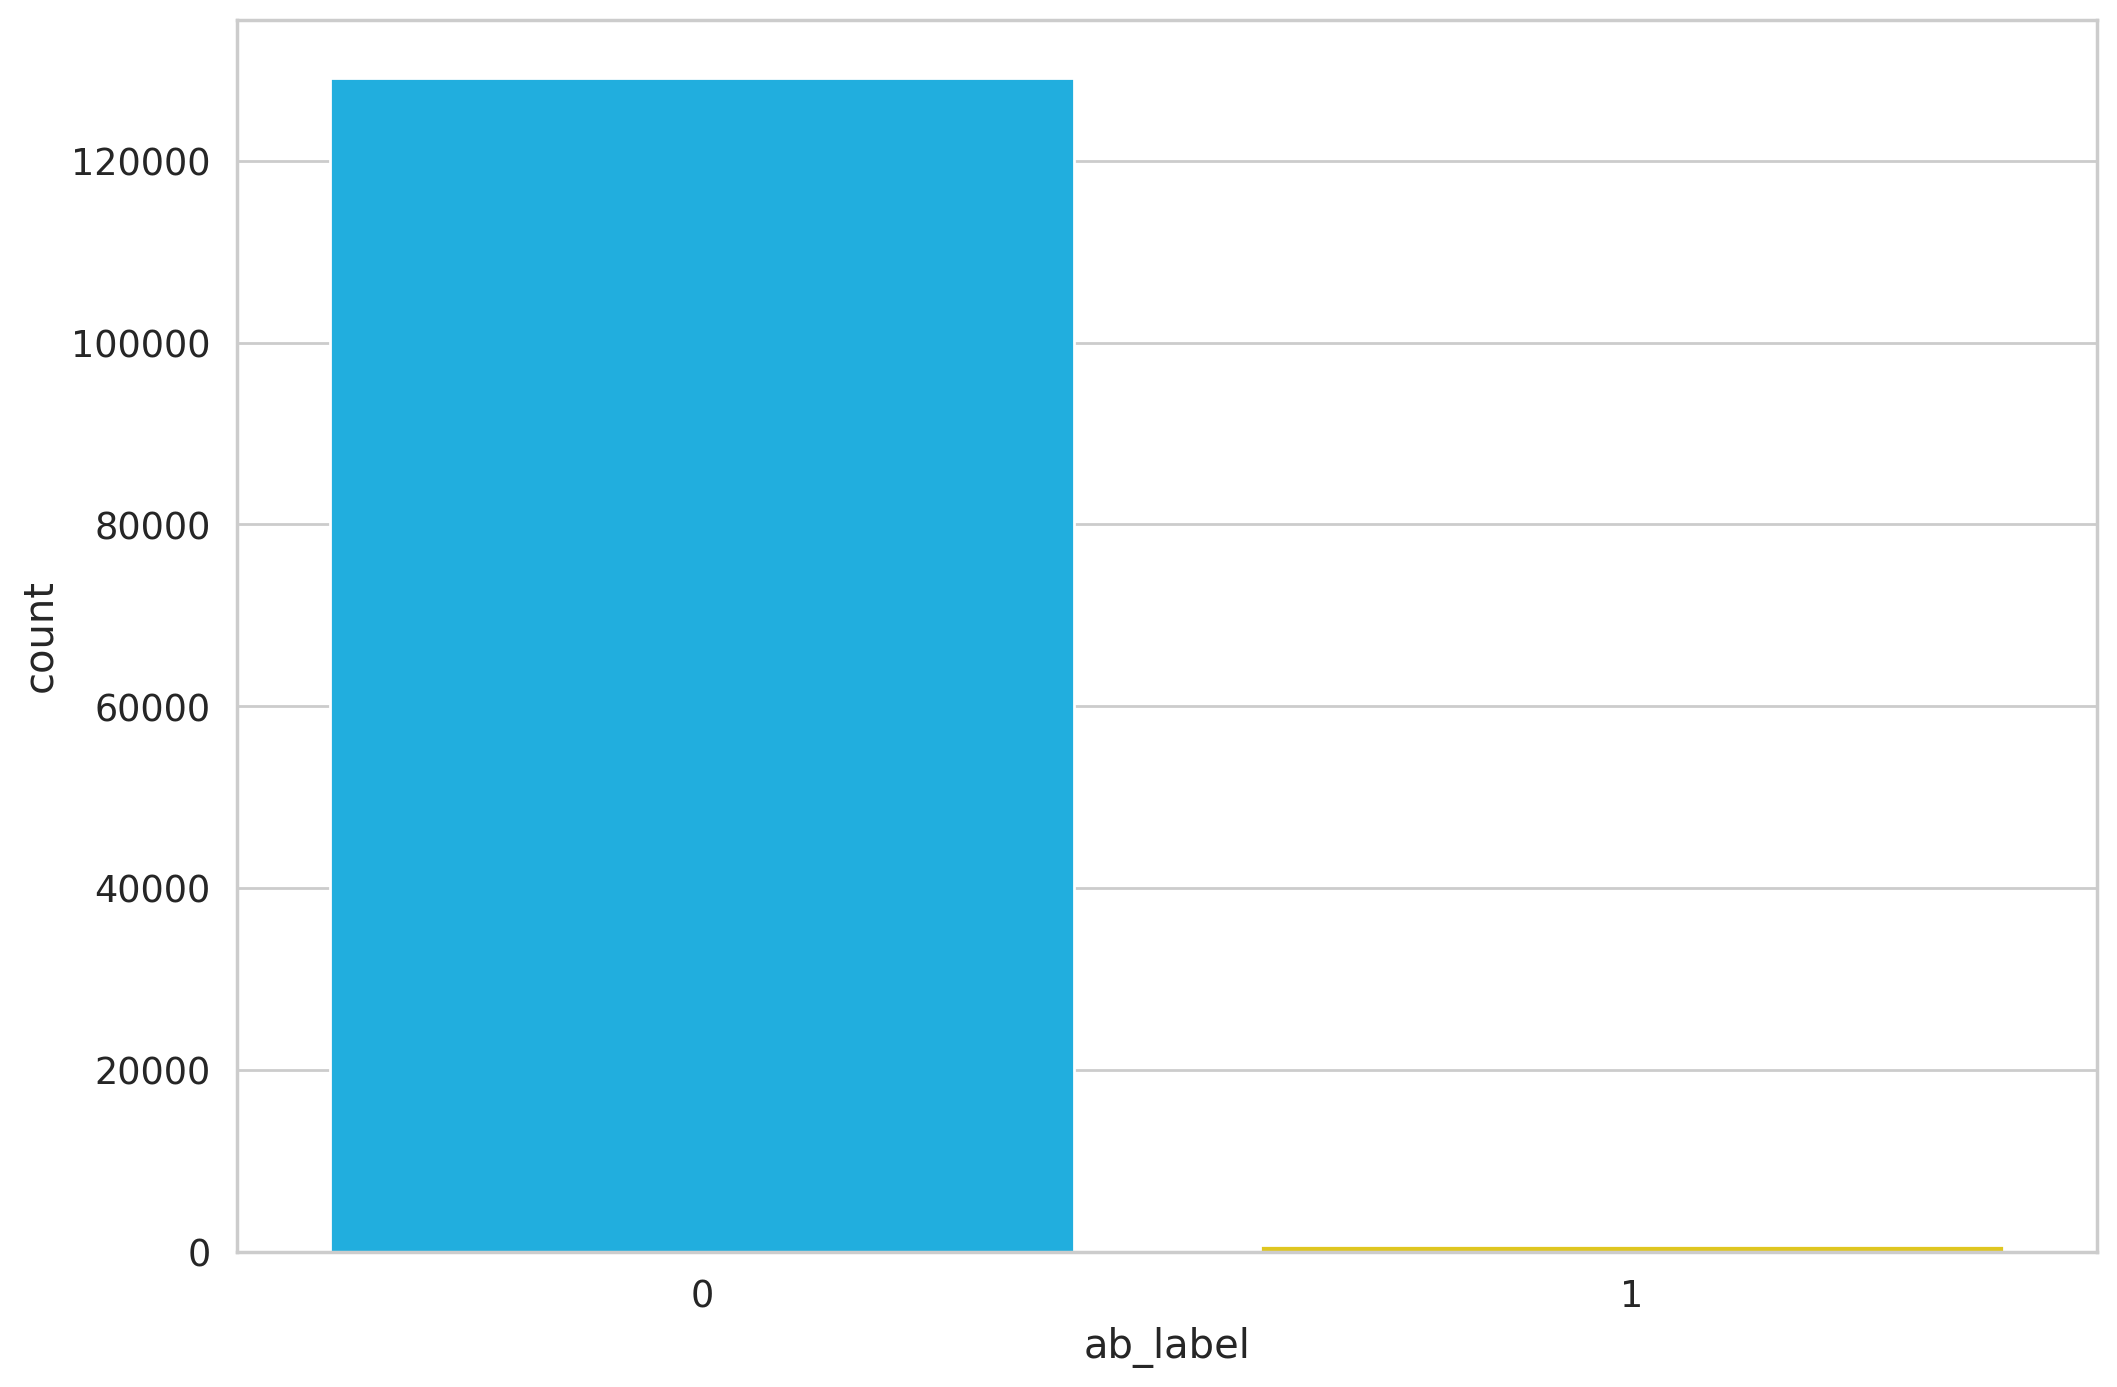

In [12]:
ax = sns.countplot(x='ab_label', data=df)
ax.set_xticklabels(class_names);

The chart looks different from the original workbook. The order of the bars are misaligned.

In [18]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

/tmp/ipykernel_1284513/728600574.py:12: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = df[df['ab_label'] == cls] \
/tmp/ipykernel_1284513/728600574.py:12: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = df[df['ab_label'] == cls] \


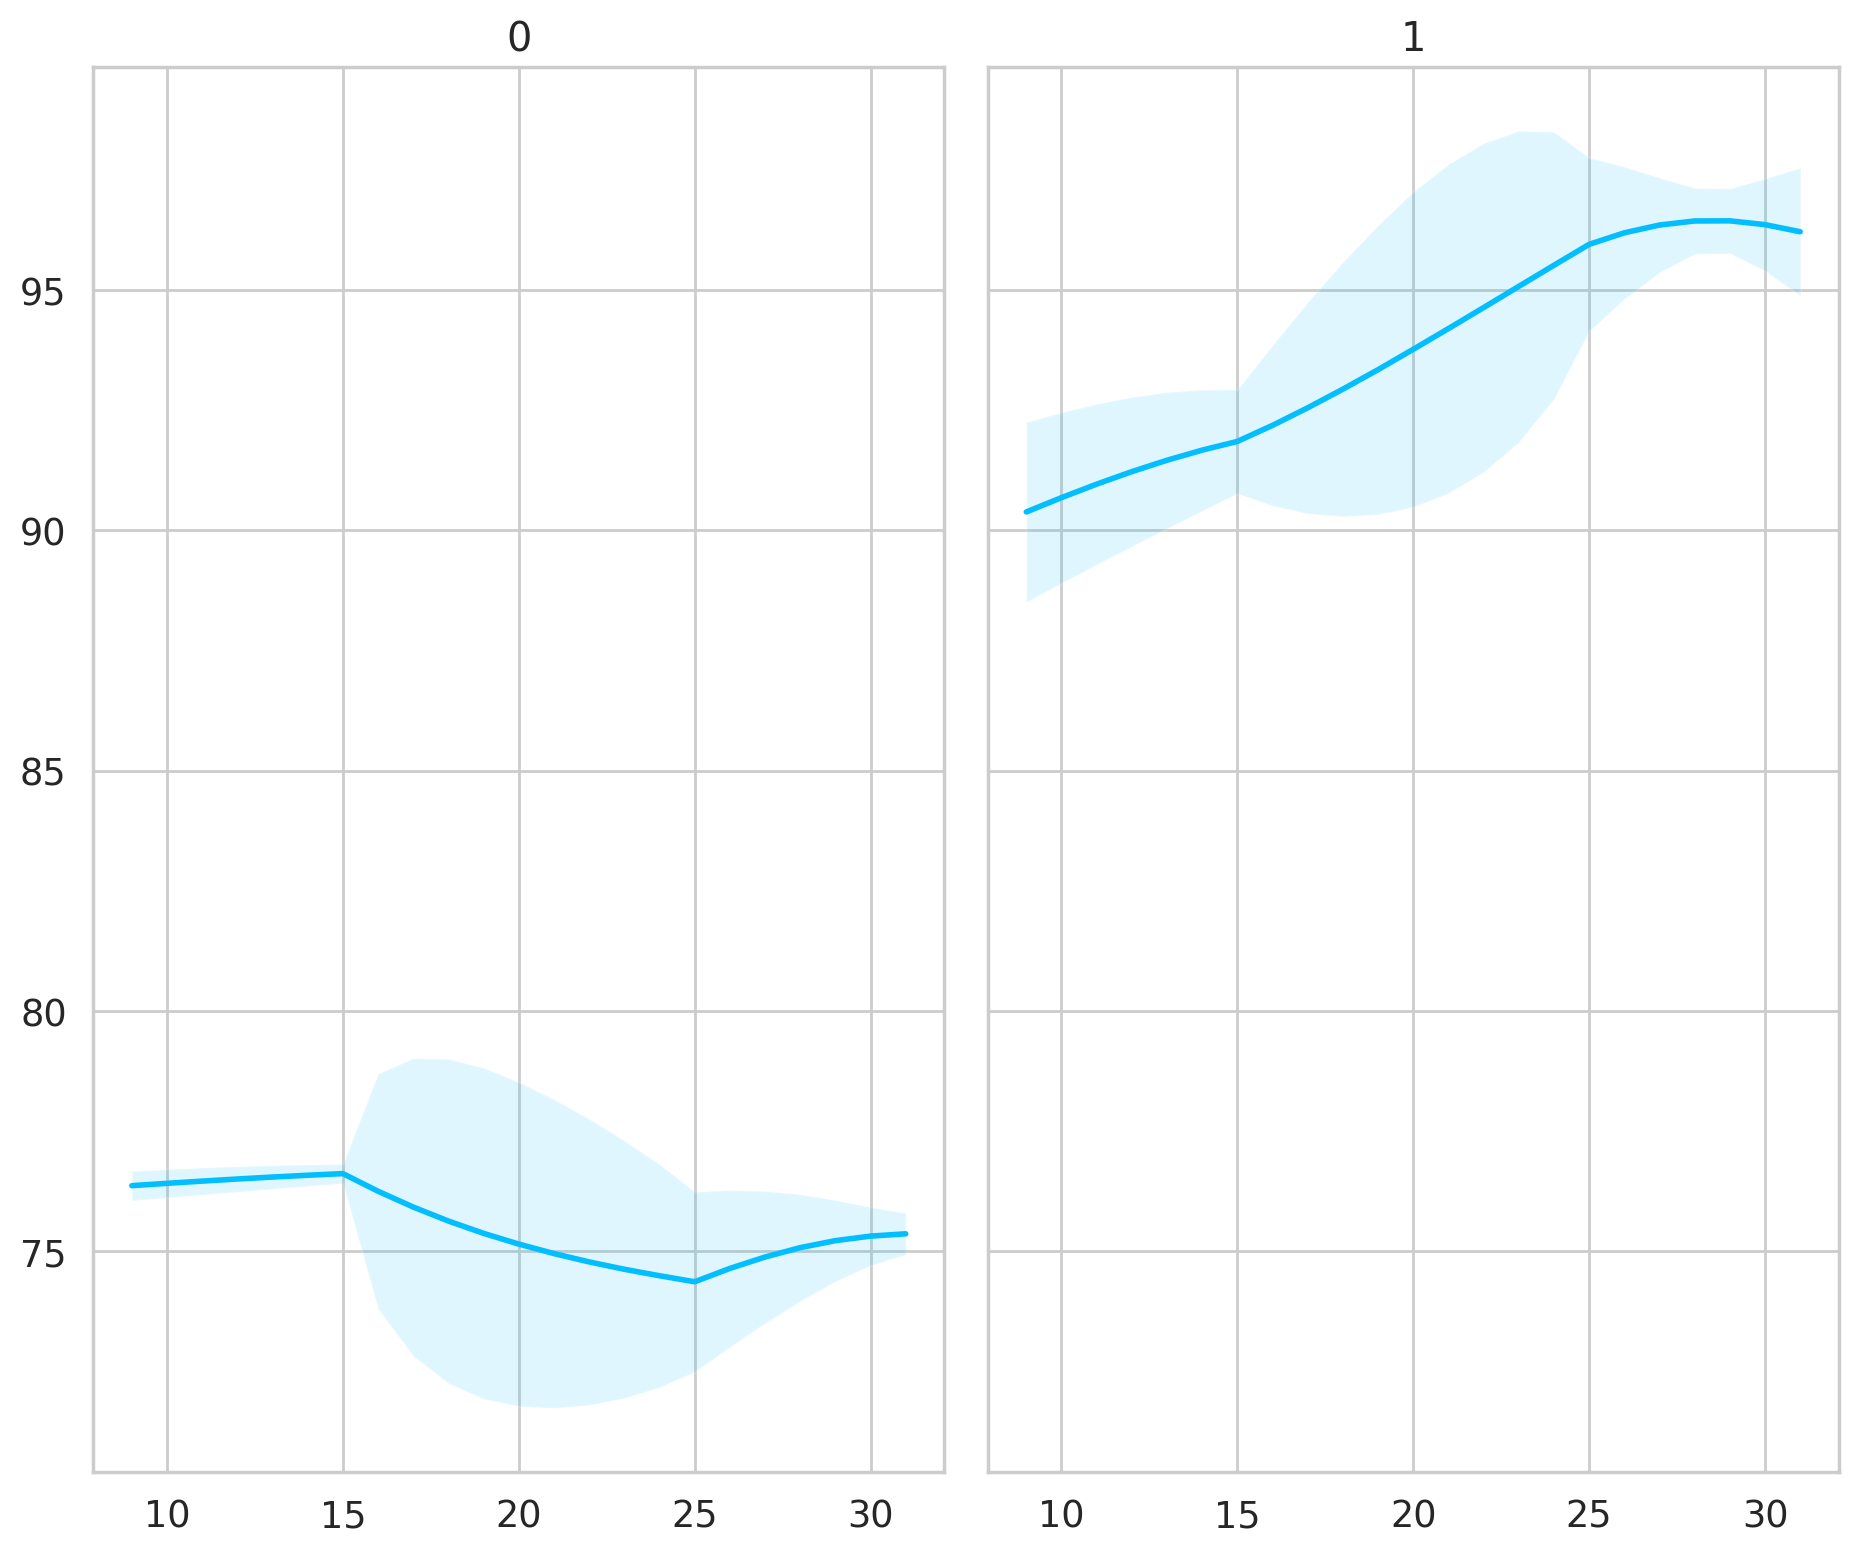

In [19]:
classes = df['ab_label'].unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df['ab_label'] == cls] \
    .drop(labels='ab_label', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

The shapes look the same to the original.

## Anomaly Detection in ECG Data

### Data Preprocessing

In [37]:
df_lab = df.drop(columns=['otemp' + str(i) for i in range(16)] + ['loc', 'start', 'end'])
df_lab

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15,ab_label
0,71.3,73.5,73.8,70.6,72.2,74.6,72.0,70.7,73.3,73.4,70.7,71.7,74.5,71.9,70.5,73.0,0
1,76.3,77.8,77.4,76.5,76.6,77.6,77.1,76.2,73.5,74.9,76.7,77.5,77.8,77.4,77.6,76.1,0
2,73.4,73.7,73.6,73.5,73.4,73.5,73.7,73.8,73.7,73.5,73.5,73.6,73.9,73.4,73.4,73.8,0
3,77.9,78.0,78.2,78.1,78.0,77.9,78.1,78.2,78.1,78.2,78.2,78.3,78.2,78.3,78.2,78.3,0
4,72.4,73.0,73.2,73.0,72.1,71.8,72.2,71.8,72.3,72.5,73.4,73.2,72.6,72.3,71.8,72.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129787,71.6,70.9,71.0,70.0,70.7,70.0,69.2,70.1,70.0,70.5,71.1,71.5,72.3,73.0,73.3,73.8,0
129788,81.8,81.9,82.0,82.0,82.2,82.3,82.5,82.6,82.7,82.8,82.9,83.1,83.2,83.4,83.5,83.7,0
129789,75.5,75.7,76.0,76.1,76.3,76.3,76.4,76.3,76.5,76.4,76.4,76.4,76.1,75.7,75.5,74.9,0
129790,75.2,75.6,75.7,76.1,76.5,76.7,76.9,77.4,77.8,77.8,77.5,77.7,77.5,77.5,77.4,77.3,0


In [38]:
df_ab = df_lab[lambda df: df['ab_label'] == 1].drop(labels='ab_label', axis=1)
df_ab

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15
191,79.3,80.2,80.2,80.5,80.5,84.1,88.4,90.3,91.7,92.7,93.4,93.9,94.3,94.6,89.7,86.4
500,88.8,89.2,89.6,89.7,89.7,89.6,89.6,89.8,90.2,90.6,91.1,91.5,91.8,92.2,92.4,92.7
519,85.9,86.3,86.8,87.1,87.5,87.9,88.3,88.8,88.8,89.1,89.4,89.7,90.0,90.4,90.8,91.2
573,90.4,91.1,91.5,92.2,92.6,92.9,93.3,93.6,94.1,94.4,94.9,95.1,95.2,95.0,95.0,94.9
606,89.6,90.2,90.8,91.1,91.4,91.8,92.5,92.7,92.6,92.7,92.6,92.4,92.4,92.6,92.6,92.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128976,88.9,89.6,89.6,89.8,90.2,90.6,90.9,91.3,92.0,92.1,92.0,91.6,90.9,90.6,90.1,89.9
129138,85.3,85.7,86.2,86.5,87.0,87.5,87.8,87.9,88.3,88.5,88.7,89.2,89.5,90.1,90.8,91.2
129148,85.6,86.1,86.6,86.9,87.6,88.3,89.2,89.9,90.4,91.1,91.5,92.2,92.6,92.9,93.3,93.6
129220,96.7,96.8,97.3,97.4,97.6,97.6,97.3,97.4,97.4,97.4,97.4,97.4,97.4,97.4,97.4,97.3


In [39]:
df_n = df_lab[lambda df: df['ab_label'] == 0].drop(labels='ab_label', axis=1)
df_n

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15
0,71.3,73.5,73.8,70.6,72.2,74.6,72.0,70.7,73.3,73.4,70.7,71.7,74.5,71.9,70.5,73.0
1,76.3,77.8,77.4,76.5,76.6,77.6,77.1,76.2,73.5,74.9,76.7,77.5,77.8,77.4,77.6,76.1
2,73.4,73.7,73.6,73.5,73.4,73.5,73.7,73.8,73.7,73.5,73.5,73.6,73.9,73.4,73.4,73.8
3,77.9,78.0,78.2,78.1,78.0,77.9,78.1,78.2,78.1,78.2,78.2,78.3,78.2,78.3,78.2,78.3
4,72.4,73.0,73.2,73.0,72.1,71.8,72.2,71.8,72.3,72.5,73.4,73.2,72.6,72.3,71.8,72.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129787,71.6,70.9,71.0,70.0,70.7,70.0,69.2,70.1,70.0,70.5,71.1,71.5,72.3,73.0,73.3,73.8
129788,81.8,81.9,82.0,82.0,82.2,82.3,82.5,82.6,82.7,82.8,82.9,83.1,83.2,83.4,83.5,83.7
129789,75.5,75.7,76.0,76.1,76.3,76.3,76.4,76.3,76.5,76.4,76.4,76.4,76.1,75.7,75.5,74.9
129790,75.2,75.6,75.7,76.1,76.5,76.7,76.9,77.4,77.8,77.8,77.5,77.7,77.5,77.5,77.4,77.3


In [40]:
train_df, val_df = train_test_split(
  df_ab,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [41]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [43]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(df_n)

### Model Definitions

In [44]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [45]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [46]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [47]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, )
model = model.to(device)

### Training

In [51]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [71]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=10
)

Epoch 1: train loss 1334.507829733456 val loss 1235.3308535293795
Epoch 2: train loss 1154.0462149996717 val loss 1068.547392509353
Epoch 3: train loss 989.9560868976497 val loss 906.2551303917254
Epoch 4: train loss 828.5695126830029 val loss 745.5520913567342
Epoch 5: train loss 668.2707440544577 val loss 585.5729726871974
Epoch 6: train loss 508.4940307104287 val loss 425.95985391106404
Epoch 7: train loss 348.98845838017826 val loss 266.7180407886774
Epoch 8: train loss 192.43782210149683 val loss 118.26174282020247
Epoch 9: train loss 73.12277230655445 val loss 59.02876228010151
Epoch 10: train loss 55.31327172287372 val loss 59.33891049237319


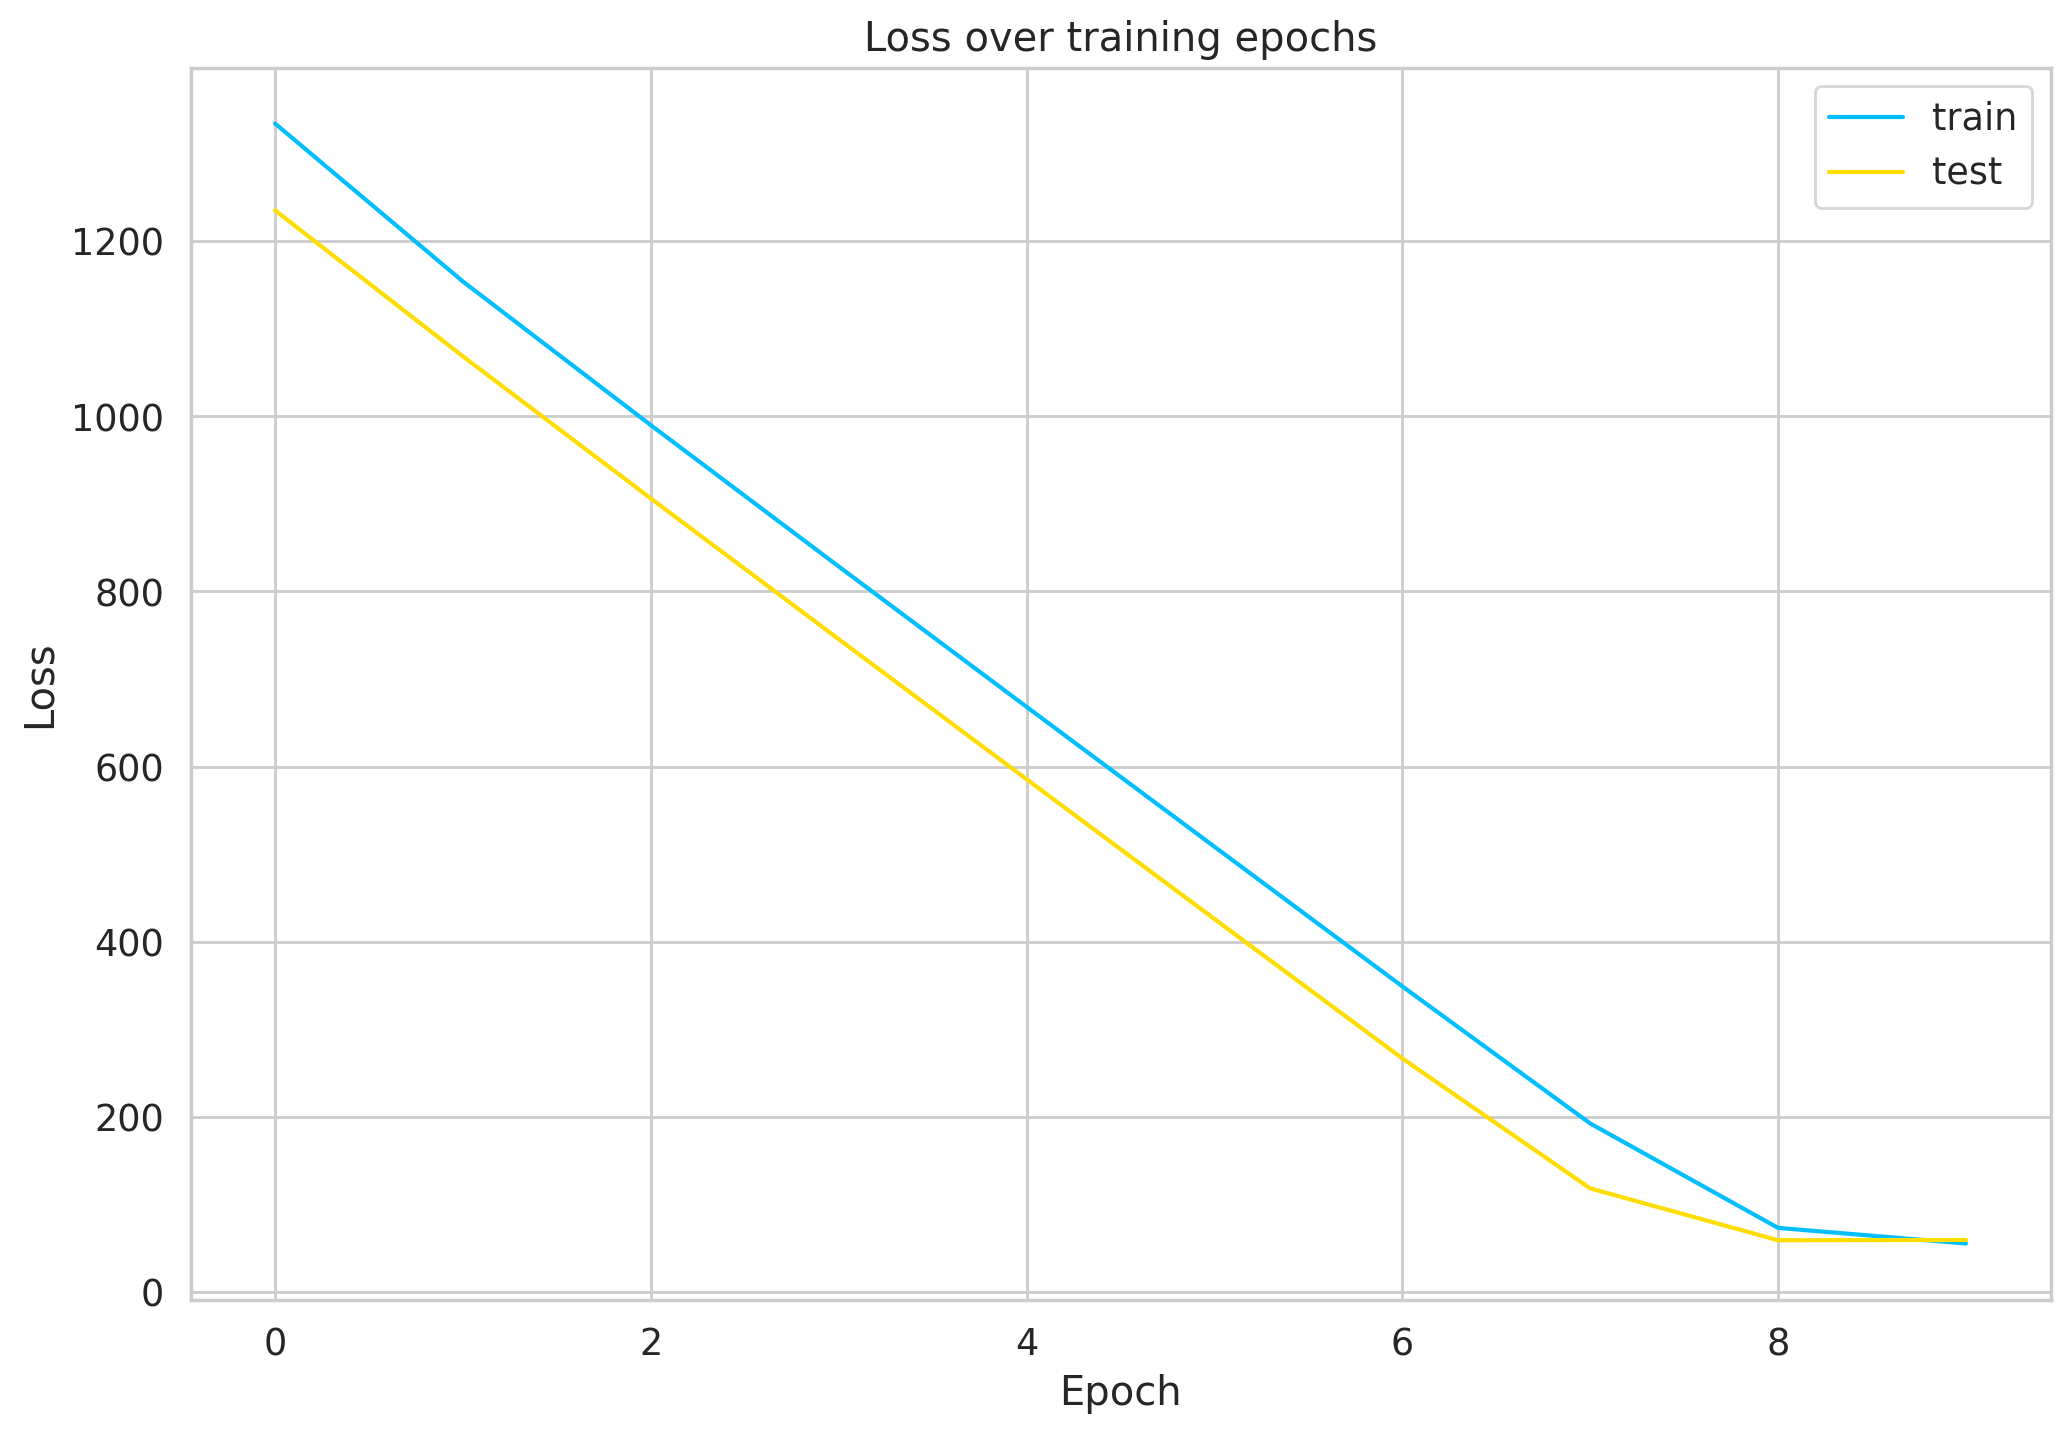

In [72]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

### Saving the model

In [40]:
MODEL_PATH = '../../model/ecg_autoencoder_model.pth'

torch.save(model, MODEL_PATH)

### Choosing a threshold

In [60]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/tmp/ipykernel_1284513/1153265548.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


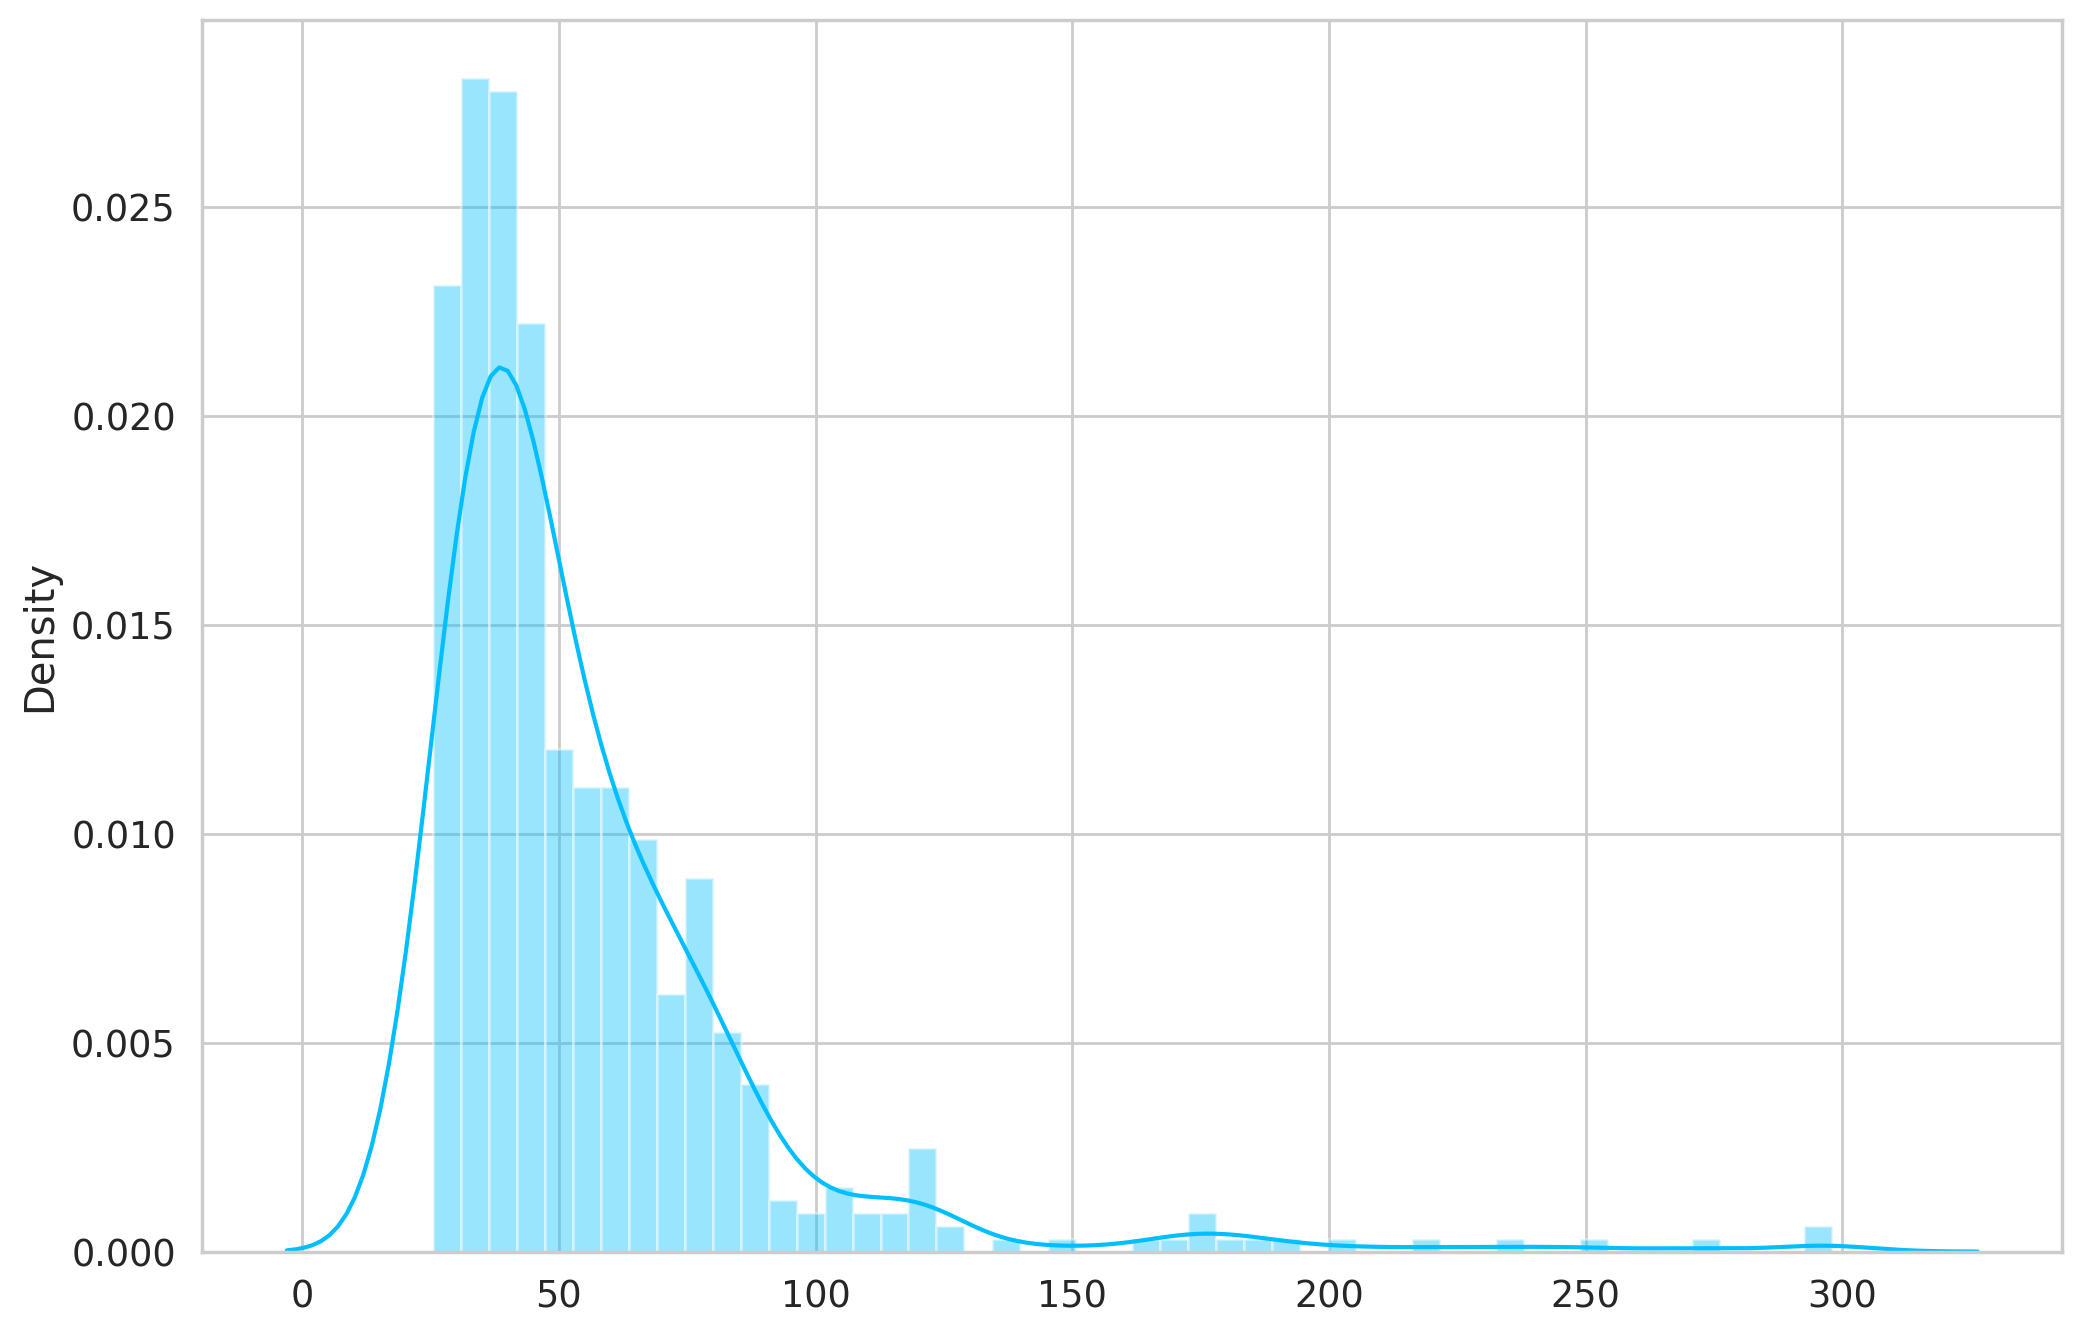

In [73]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [74]:
THRESHOLD = 150 # 26

### Evaluation

#### Normal hearbeats

/tmp/ipykernel_1284513/3242963548.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


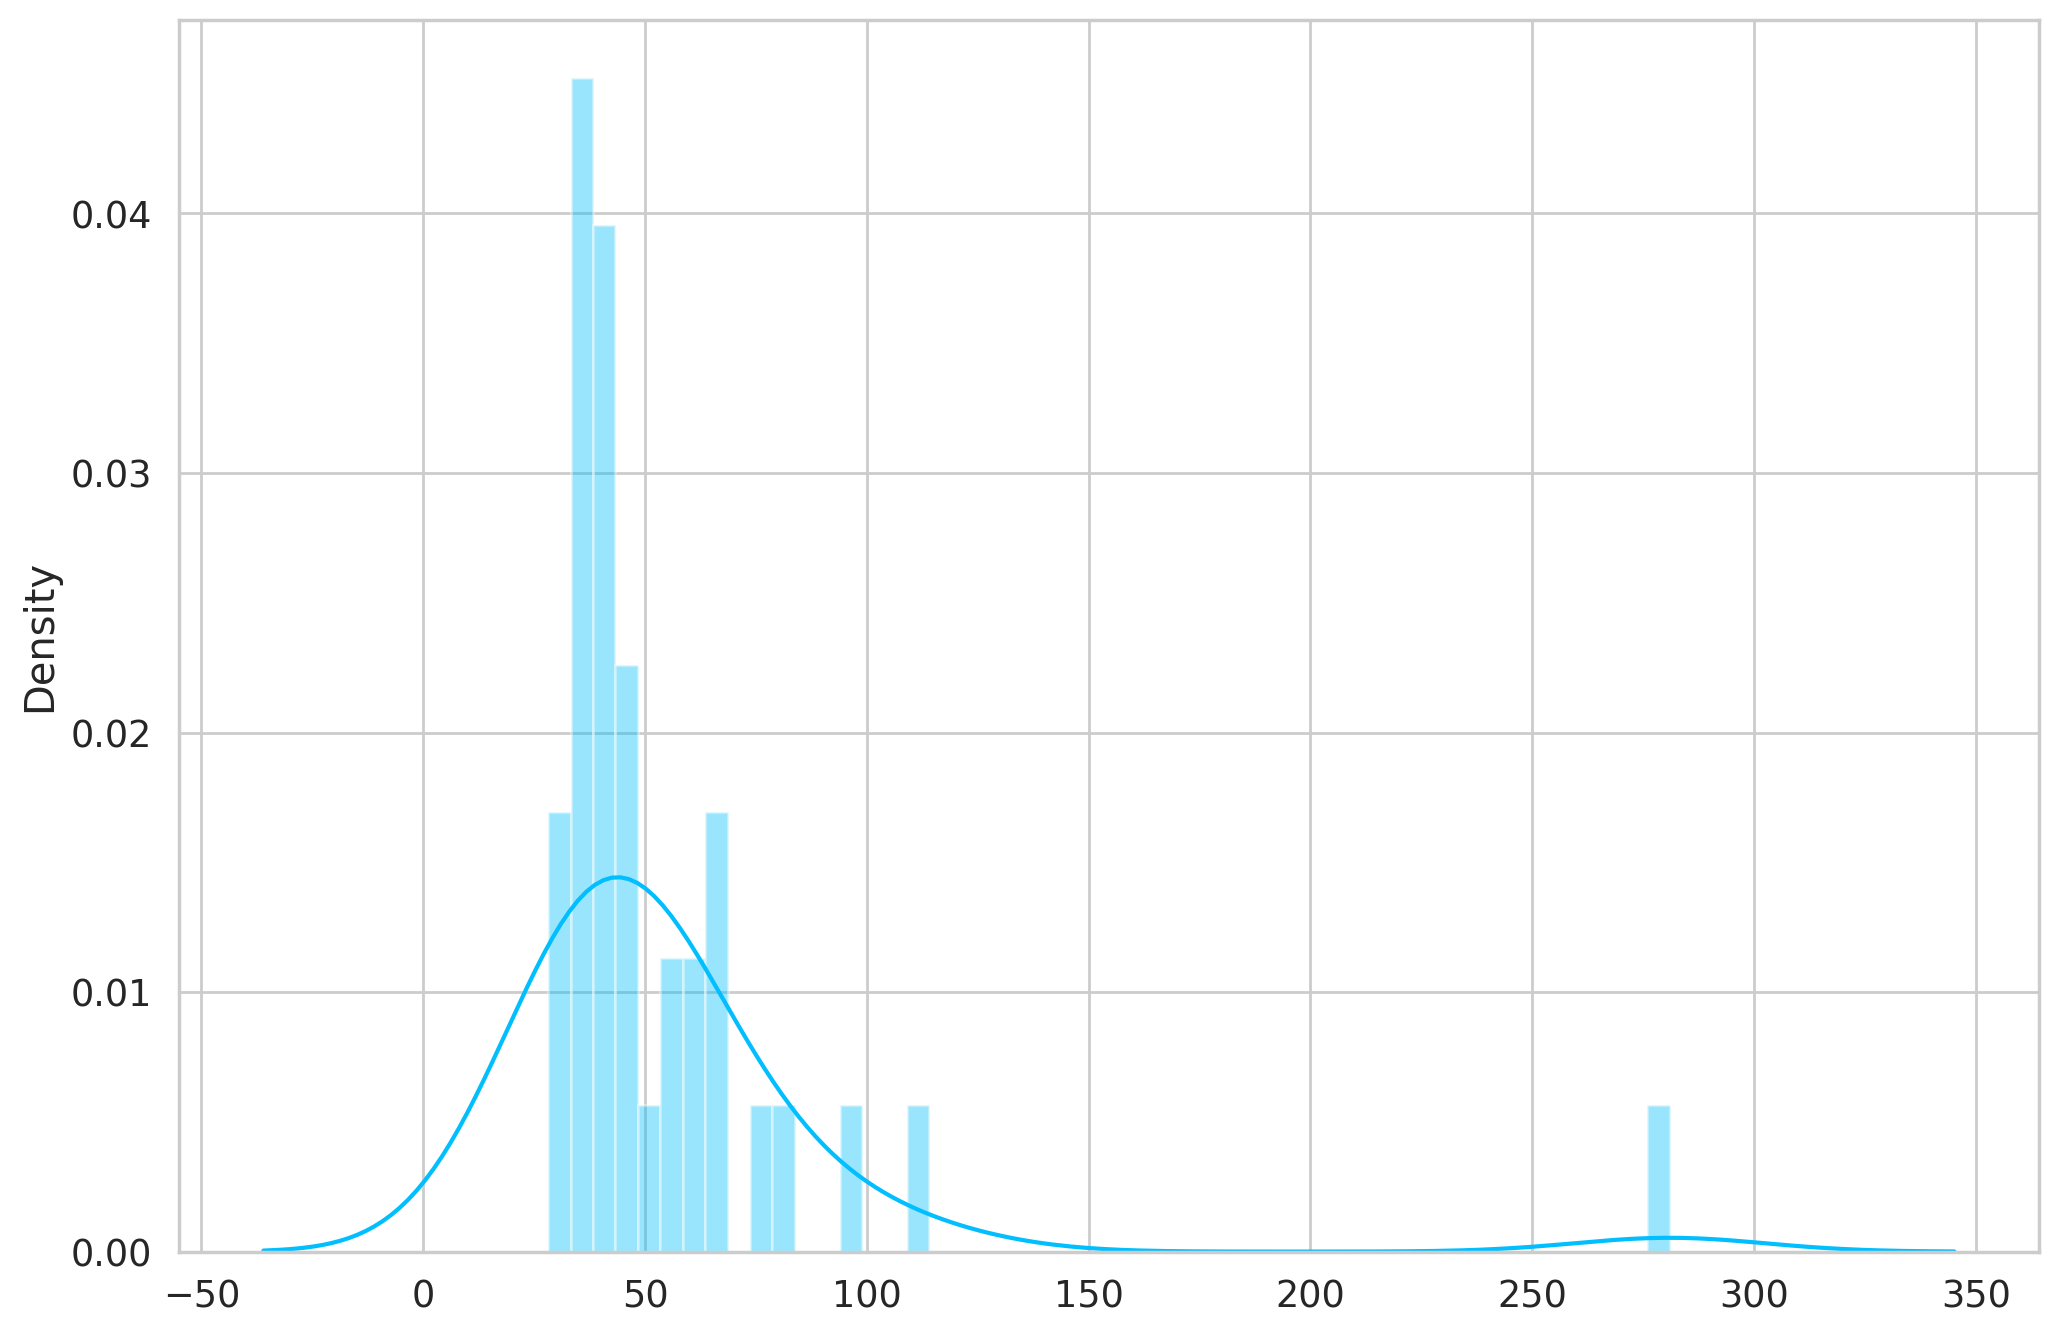

In [75]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [76]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 34/35


#### Anomalies

In [ ]:
anomaly_dataset = test_anomaly_dataset

/tmp/ipykernel_1284513/3617888763.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


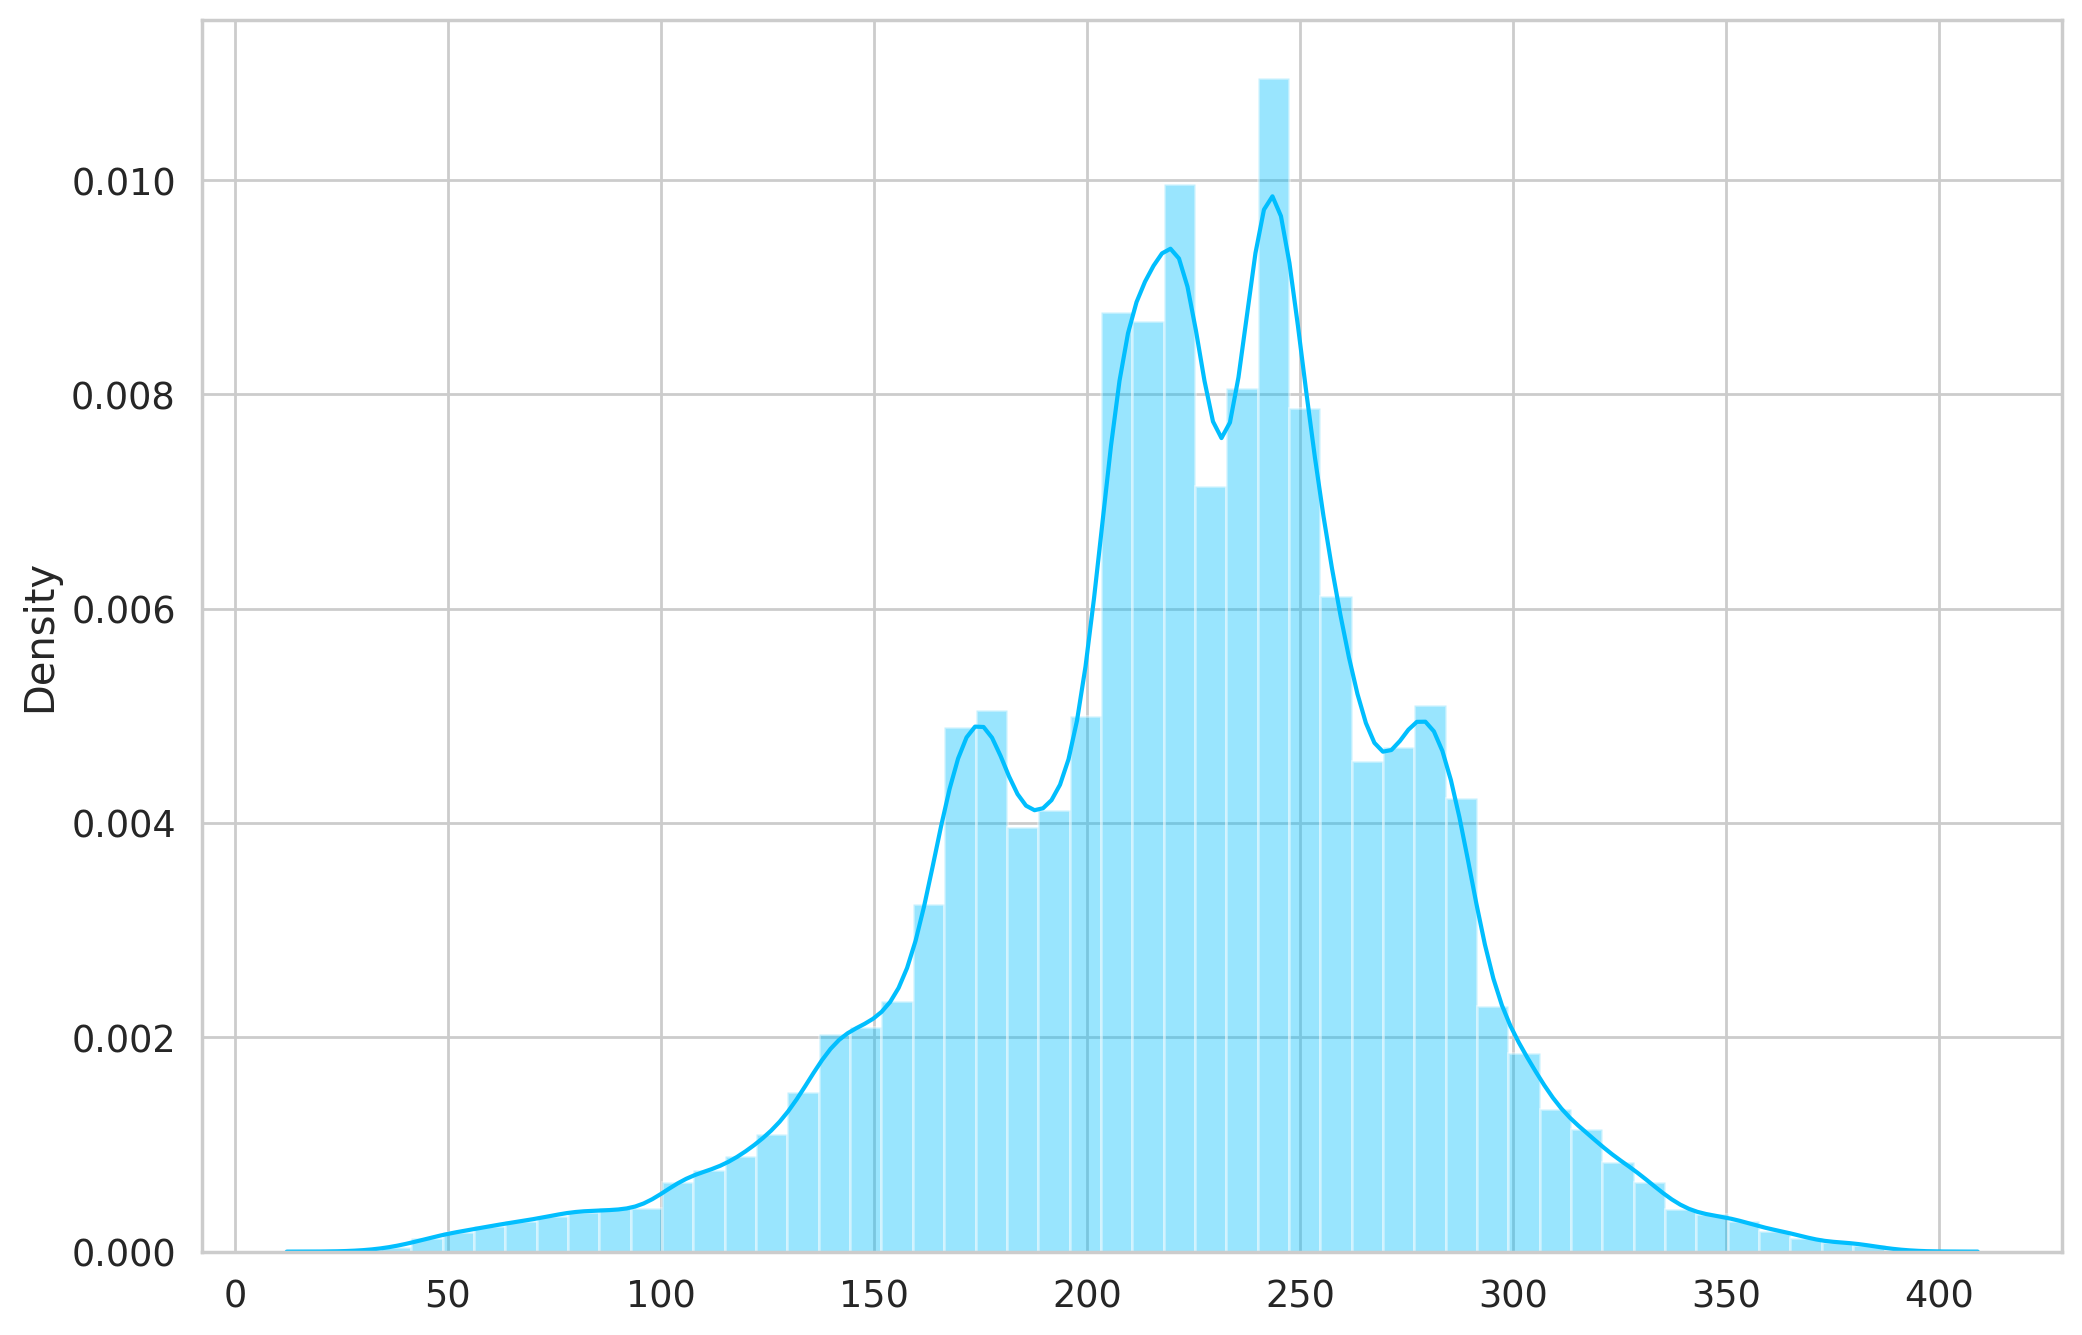

Bad pipe message: %s [b'V\x9d*\xf6\xf3\xe7lk!D`D[\xac\x86\xa8\n\xe4 >\xee\xad\x19\xa7=3\x08\xf2\xb2<q\x0bB>R\x18a\x8fH\\\xb86#~b\xf9\xf5?\xb9\xf4H\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0']
Bad pipe message: %s [b'.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04']
Bad pipe message: %s [b'\x03\x06', b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x89@\xd1\xe8[\xf6\xc4\xdb\x91\xbd\x85\xd3\xedQ\xd3\x14?\xfe:\xb39\xea']
Bad pipe message: %s [b'D\xf5\x05\x9e\xcc\xd9\xa6\xaf\xeb\x15\xb5\xb3\x01S|\xb2\x8f\x0f %BZ0<\xff\xbe\x14k:A\x9e\xce\x84\xa8o\xd1\xba\x1b', b'H\xd1\x0b\x9a\x1a']
Bad pipe message: %s [b"\xd0X\xaa\x02\xcc\xb1\xce\xce@\x98\xdc\x12L\x12\x95\xc7\x

In [85]:
predictions, pred_losses = predict(model, test_anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [79]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 34/35


#### Looking at Examples

In [68]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

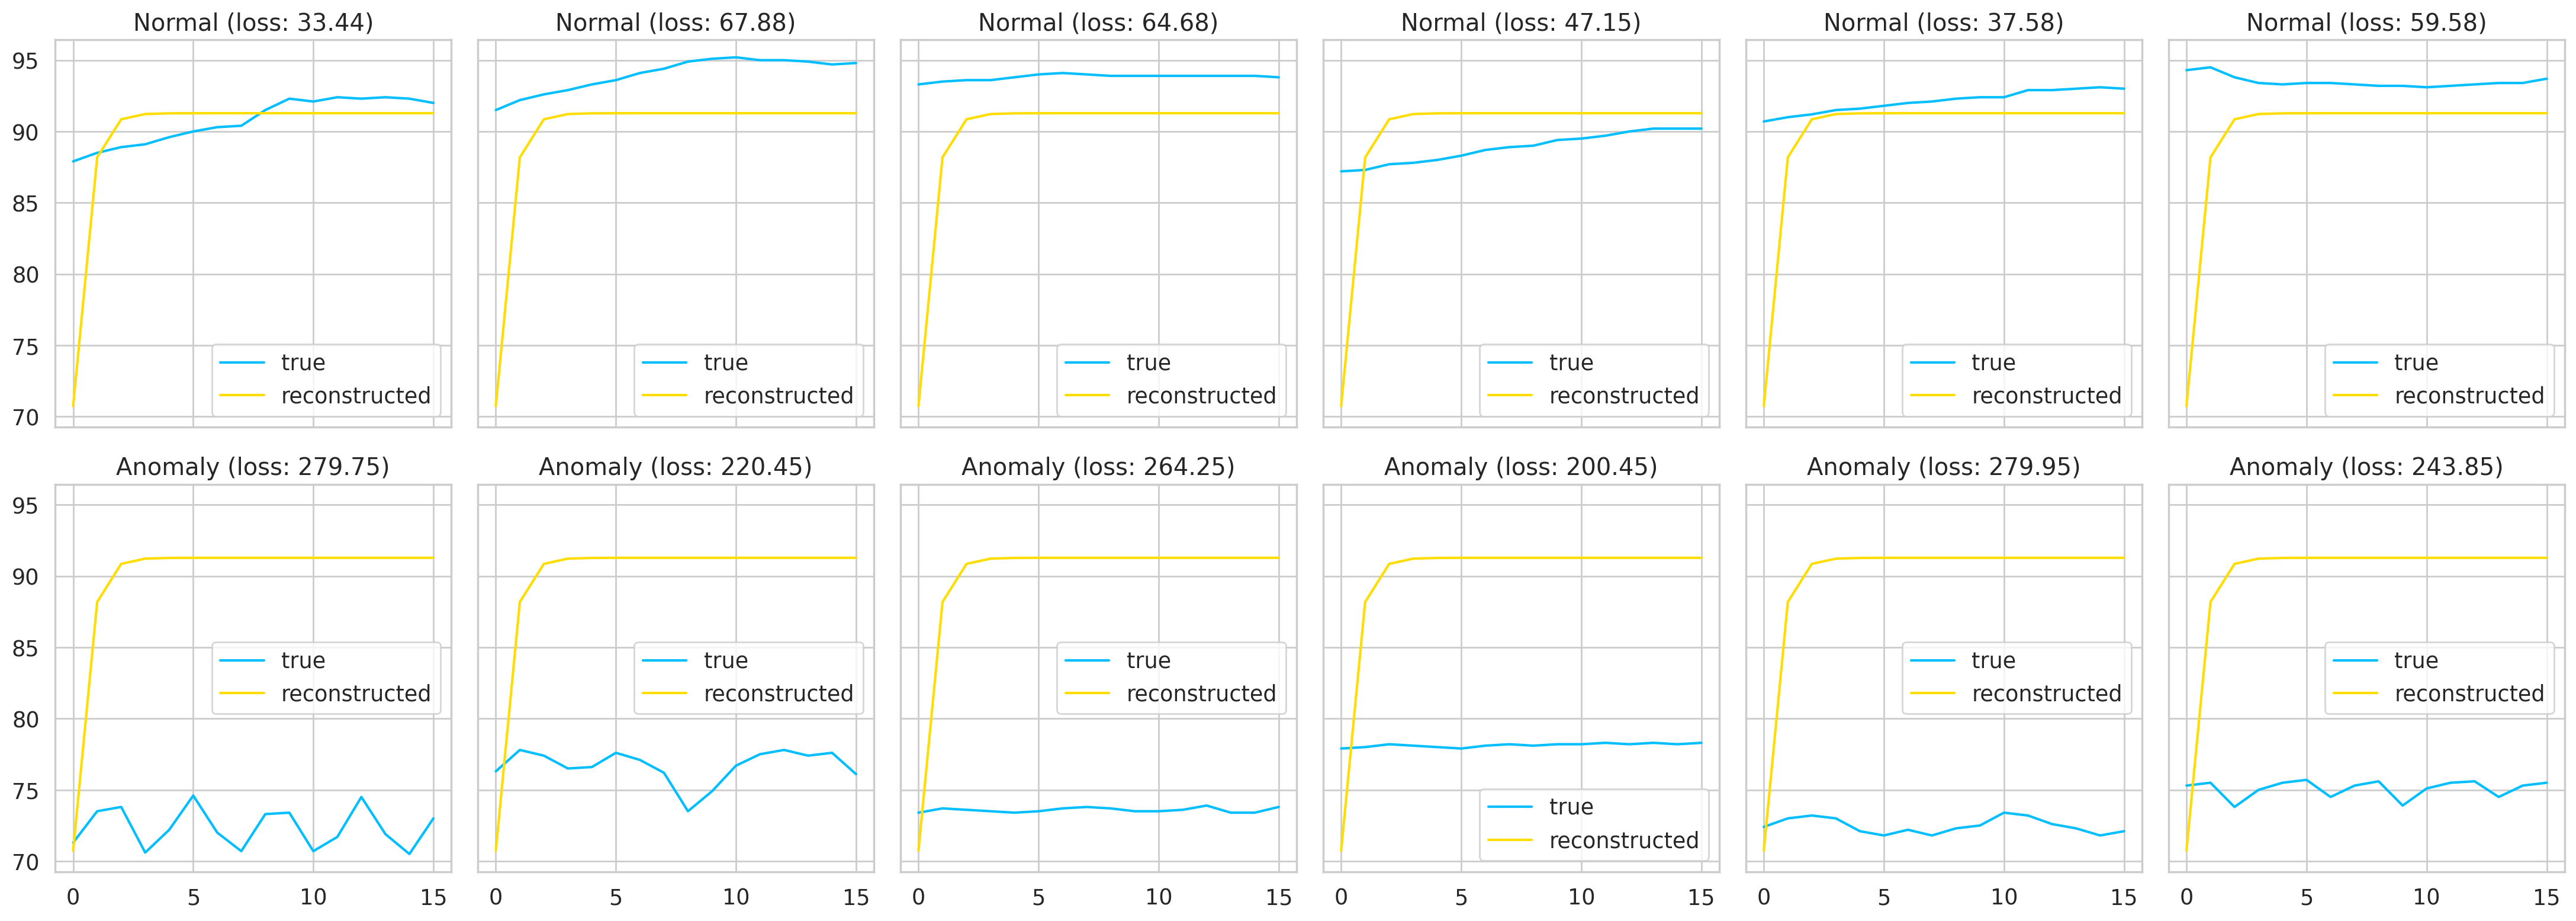

In [80]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();